# Importación de librerías y funciones necesarias

In [32]:
!pip install vaderSentiment

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import re
import unicodedata
from stop_words import get_stop_words

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Carga de datos

Voy a continuar con las reviews de las siguientes 3 categorias de Amazon del link http://jmcauley.ucsd.edu/data/amazon/

- Instant Video
- Musical Instruments
- Patio, Lawn and Garden

In [4]:
datasets_path = '../datasets'

video_json = 'reviews_Amazon_Instant_Video_5.json.gz'
instruments_json = 'reviews_Musical_Instruments_5.json.gz'
garden_json = 'reviews_Patio_Lawn_and_Garden_5.json.gz'

In [5]:
df_video = pd.read_json(os.path.join(datasets_path, video_json), lines=True, compression='gzip')
df_instruments = pd.read_json(os.path.join(datasets_path, instruments_json), lines=True, compression='gzip')
df_garden = pd.read_json(os.path.join(datasets_path, garden_json), lines=True, compression='gzip')


In [6]:
#Me quedo solo con la columna de rewviewText y overall que son las que me interesan para analizar los sentimientos
df_video=df_video.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]
df_instruments=df_instruments.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]
df_garden=df_garden.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]

In [7]:
df_video.head()

,reviewText,overall
0,I had big expectations because I love English ...,2
1,I highly recommend this series. It is a must f...,5
2,This one is a real snoozer. Don't believe anyt...,1
3,Mysteries are interesting. The tension betwee...,4
4,"This show always is excellent, as far as briti...",5


# Normalización del número de estrellas

En función del número de estrellas las reviews serán etiquetadas como
- **Negativas** (0): 1 ó 2 estrellas
- **Positivas** (1): 4 ó 5 estrellas
- **Neutrales** (2): 3 estrellas

In [24]:
df_video.loc[:, 'sentiment'] = [0 if rank < 3 else 1 if rank > 3 else 2 for rank in df_video['overall']]
df_instruments.loc[:, 'sentiment'] = [0 if rank < 3 else 1 if rank > 3 else 2 for rank in df_instruments['overall']]
df_garden.loc[:, 'sentiment'] = [0 if rank < 3 else 1 if rank > 3 else 2 for rank in df_garden['overall']]

# Trabajamos con un subset de cada corpus

Balancear el dataset con respecto a la variable objetivo nos ayudará a obtener mejores resultados

In [25]:
n_reviews_per_sentiment = 2500

df_video = df_video.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))
df_instruments = df_instruments.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))
df_garden = df_garden.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))

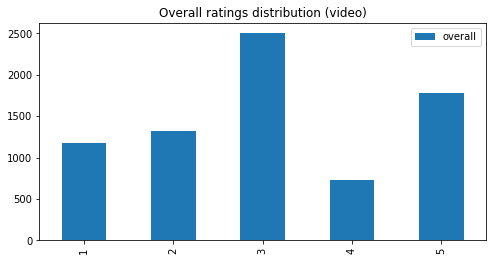

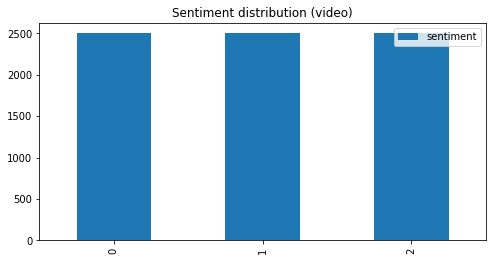

In [26]:
aux = pd.DataFrame(df_video['overall'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall ratings distribution (video)', figsize=(8, 4))

aux = pd.DataFrame(df_video['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Sentiment distribution (video)', figsize=(8, 4))

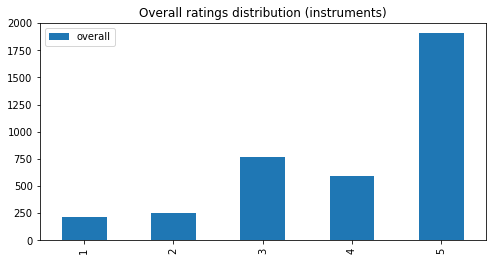

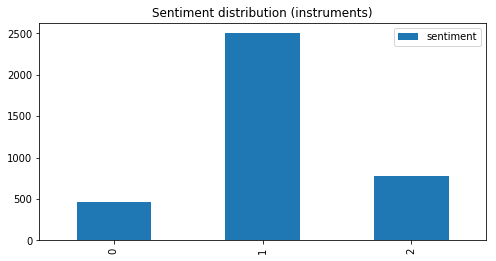

In [27]:
aux = pd.DataFrame(df_instruments['overall'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall ratings distribution (instruments)', figsize=(8, 4))

aux = pd.DataFrame(df_instruments['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Sentiment distribution (instruments)', figsize=(8, 4))

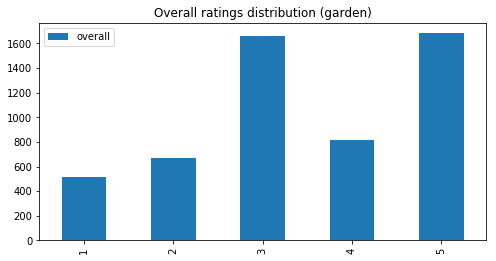

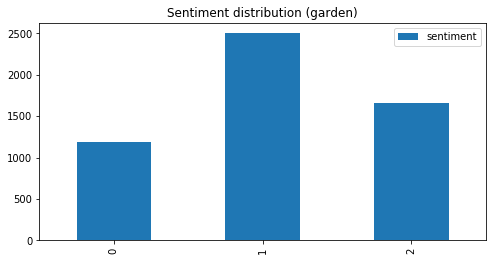

In [28]:
aux = pd.DataFrame(df_garden['overall'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall ratings distribution (garden)', figsize=(8, 4))

aux = pd.DataFrame(df_garden['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Sentiment distribution (garden)', figsize=(8, 4))

In [29]:
#Unimos los 3 DataFrames en uno
df = pd.concat([df_video, df_instruments, df_garden])

In [30]:
df.shape

(16590, 3)

# Pruebas con VADER

In [34]:
vader_analyser = SentimentIntensityAnalyzer()

In [35]:
review_test = df[df['sentiment']==0].sample(1)['reviewText'].values[0]
print(review_test)
print(vader_analyser.polarity_scores(review_test))

Dead batteries, hard to push the safety switch to the safe position while keeping the sprayer pointed away from yourself.Fine print on the bottle says do not use on food plants, even though the Amazon page said that the product is recommended for organic gardening. Being OMRI listed and USDA approved for use in organic gardening is in direct contradiction to the instructions on the bottle.I had planned on using this for my cherry tomato plants, but the instructions on the package clearly say do not use on food plants.I did sacrifice one of my tomato plants, since I felt that a test of the spray wouldn't be complete without a plant that I know the deer love to eat.It was difficult using the sprayer, first was discovering that it had dead batteries, then of course I had to find replacement batteries. Then it took quite a while for the pump to prime. The safety switch is very difficult for me to place in the safe position while pointing the sprayer away from me, it might be easier for oth

# Procesamos el texto


In [37]:
def sentence_normalization(sentence):
    sentence = unicodedata.normalize('NFKD', sentence).lower().encode('ascii', errors='ignore').decode('utf-8')
    sentence = re.sub(' +', ' ', ' '.join([word if word.isalpha() else '' for word in sentence.split()])).strip()
    return sentence

In [38]:
def remove_stopwords(sentence, sw_list):
    sentence = ' '.join([word for word in sentence.split() if word not in sw_list])
    return sentence

In [39]:
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

In [40]:
def lemmatize(sentence, lemmas_dict):
    sentence = ' '.join([lemmas_dict.get(word, word) for word in sentence.split()])
    return sentence

In [41]:
lemmas_path = '../data'
english_lemmas = 'lemmatization-en.txt'  # Fuente: https://github.com/michmech/lemmatization-lists

english_lemmas_dict = get_lemmas_dict(lemmas_path, english_lemmas)
english_lemmas_dict.get('running')

In [42]:
# Stop words
sw_list = get_stop_words('en')
sw_list[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

In [43]:
processed_sentences = []

for sent in df['reviewText']:
    sent = sentence_normalization(sent)
    sent = remove_stopwords(sent, sw_list)
    sent = lemmatize(sent, english_lemmas_dict)
    processed_sentences.append(sent)

In [44]:
df['processed_review'] = processed_sentences

In [45]:
df.head()

,reviewText,overall,sentiment,processed_review
23883,I found this show so unappealing I couldn't st...,1,0,found show unappealing stand waste time whole ...
28452,This show was ok at one time. It was entertain...,1,0,show ok one entertaining science sparked much ...
27524,This movie tries too hard to be smart and witt...,1,0,movie tries hard smart witty instead just ramb...
772,"Ok, here's the thing with this show..everyone ...",1,0,thing story line fine writing good set love pa...
3508,This show is a series of melodramatic storylin...,1,0,show series melodramatic storylines songs numb...


In [46]:
print('Raw review:\n{}\n\n'.format(df['reviewText'].iloc[100]))
print('Processed review:\n{}'.format(df['processed_review'].iloc[100]))

Raw review:
I never liked this show , it was repulsive and tried to make likable characters out of drug dealers and killers . This was more like the modern day Roman Gladiator games than a tv show .


Processed review:
never liked show repulsive tried make likable characters drug dealers killers like modern day roman gladiator games tv show


# Definimos los siguientes experimentos para el entrenamiento y validación de modelos de clasificación de reviews de Amazon en función del sentimiento inferido en ellos

La representación de las reviews la realizaremos vectorizando los documentos con el TfidfVectorizer

- Modelo de **clasificación binaria** (reviews positivas y negativas) **sin procesado de texto**
- Modelo de **clasificación binaria** (reviews positivas y negativas) **con procesado de texto**
- Modelo de **clasificación binaria** (reviews positivas y negativas) **con procesado de texto** y **algunos parámetros configurados en el vectorizer**
- Modelo de **clasificación multi**-clase (reviews positivas, negativas y neutras) **sin procesado de texto**
- Modelo de **clasificación multi**-clase (reviews positivas, negativas y neutras) **con procesado de texto**
- Modelo de **clasificación multi**-clase (reviews positivas, negativas y neutras) **con procesado de texto** y **algunos parámetros configurados en el vectorizer**

Para todos los experimentos se entrenarán los mismos modelos, con igual política de búsqueda de hiperparámetros y mismos porcentajes para train y test.

In [50]:
def get_classification_sentiment_model_results(
    reviews,
    sentiment,
    max_df=1.00,
    min_df=1,
    max_features=None,
    ngram_range=(1, 1),
    multi=False,
    visualize=False
):

    # Dividir en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        reviews,
        sentiment,
        train_size=0.75,
        test_size=0.25,
        random_state=1,
        shuffle=True,
        stratify=sentiment
    )
    
    # Extracción de características (matriz documento-término de scores TF-IDF)
    cv = TfidfVectorizer()
    cv.fit(X_train)
    X_train_ = cv.transform(X_train)
    X_test_ = cv.transform(X_test)
    
    train_acc = []
    test_acc = []
    if not multi:  # Clasificación binaria
        # Tunning sobre una Logistic Regression
        c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]
        lr_models = []

        for c in c_params:
            lr = LogisticRegression(C=c, solver='lbfgs', max_iter=3000)
            lr.fit(X_train_, y_train)

            train_predict = lr.predict(X_train_)
            test_predict = lr.predict(X_test_)
            train_acc.append(accuracy_score(y_train, train_predict))
            test_acc.append(accuracy_score(y_test, test_predict))
            lr_models.append(lr)
            
        # Predecir con el modelo "óptimo"
        lr_ = lr_models[np.argmax(test_acc)]
        test_predict = lr_.predict(X_test_)

    else:  # Clasificación multi-clase, sin hyperparameter tunning
        mnb_model = MultinomialNB()
        mnb_model.fit(X_train_, y_train)
        test_predict = mnb_model.predict(X_test_)
    
    # Visualizar resultados
    if visualize and not multi:
        plt.figure(figsize=(12, 8))
        plt.plot(train_acc, label='train')
        plt.plot(test_acc, label='test')
        plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
        plt.title('Accuracy evolution for different C values')
        plt.xlabel('C')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.xticks(list(range(len(c_params))), c_params)
        plt.tight_layout()
        plt.show()
    
    
    # Confusion matrix, classification report y accuracy score para el clasificador "óptimo"
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

## Sin procesado de texto + Clasificación binaria

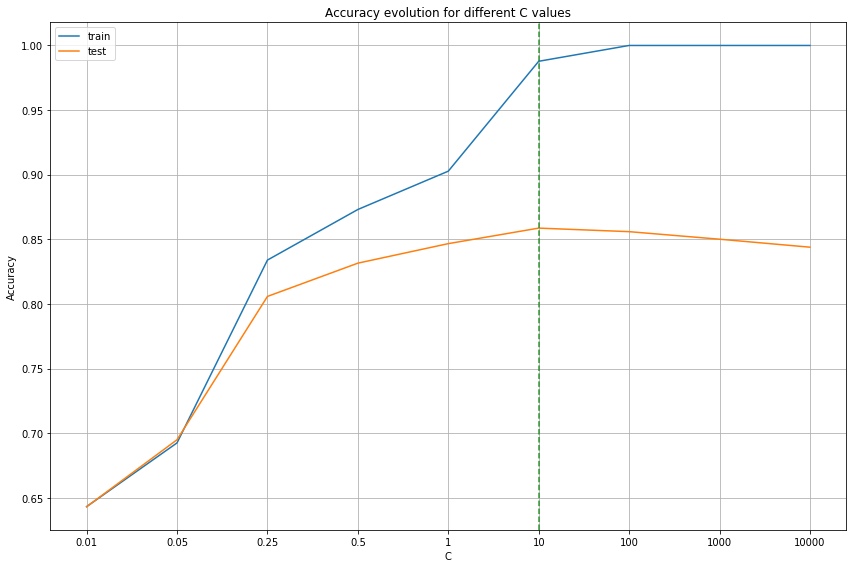

Confussion matrix:
[[ 784  256]
 [ 156 1719]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1040
           1       0.87      0.92      0.89      1875

   micro avg       0.86      0.86      0.86      2915
   macro avg       0.85      0.84      0.84      2915
weighted avg       0.86      0.86      0.86      2915

Accuracy score:0.8586620926243568


In [51]:
get_classification_sentiment_model_results(
    reviews=df[df['sentiment'] != 2]['reviewText'],
    sentiment=df[df['sentiment'] != 2]['sentiment'],
    multi=False,
    visualize=True
)

## Con procesado de texto + Clasificación binaria

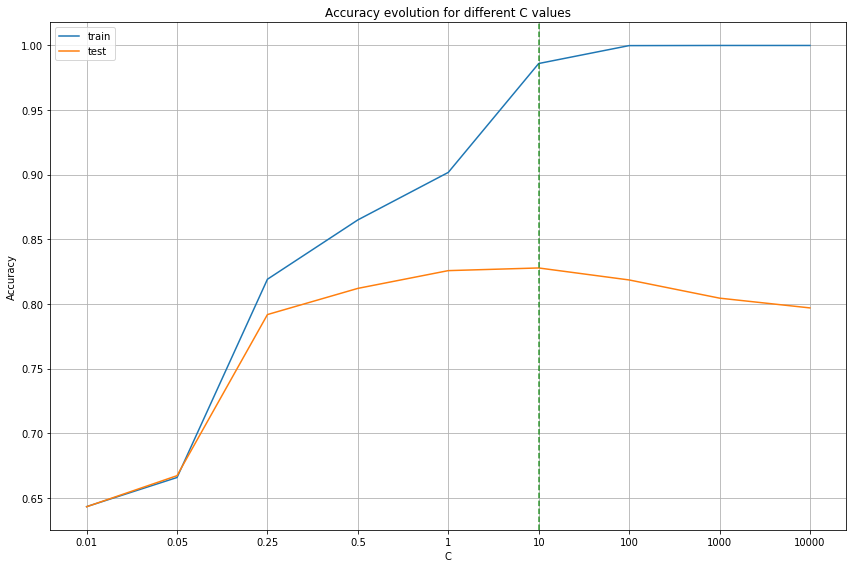

Confussion matrix:
[[ 740  300]
 [ 202 1673]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1040
           1       0.85      0.89      0.87      1875

   micro avg       0.83      0.83      0.83      2915
   macro avg       0.82      0.80      0.81      2915
weighted avg       0.83      0.83      0.83      2915

Accuracy score:0.8277873070325901


In [52]:
get_classification_sentiment_model_results(
    reviews=df[df['sentiment'] != 2]['processed_review'],
    sentiment=df[df['sentiment'] != 2]['sentiment'],
    multi=False,
    visualize=True
)

## Con procesado de texto + Clasificación binaria + Tunning TfidfVectorizer

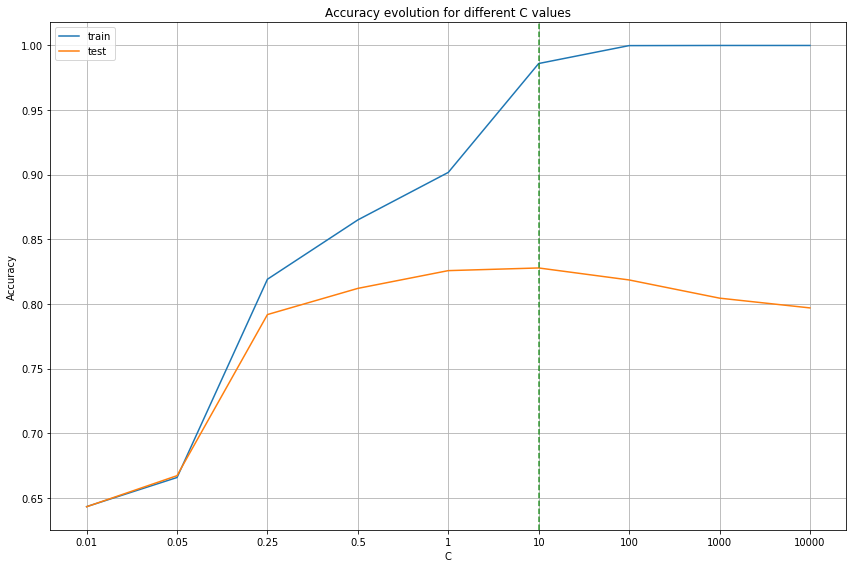

Confussion matrix:
[[ 740  300]
 [ 202 1673]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1040
           1       0.85      0.89      0.87      1875

   micro avg       0.83      0.83      0.83      2915
   macro avg       0.82      0.80      0.81      2915
weighted avg       0.83      0.83      0.83      2915

Accuracy score:0.8277873070325901


In [53]:
get_classification_sentiment_model_results(
    reviews=df[df['sentiment'] != 2]['processed_review'],
    sentiment=df[df['sentiment'] != 2]['sentiment'],
    max_df=0.95,
    min_df=15,
    max_features=3000,
    ngram_range=(2, 3),
    multi=False,
    visualize=True
)

## Sin procesado de texto + Clasificación multi-clase

In [54]:
get_classification_sentiment_model_results(
    reviews=df['reviewText'],
    sentiment=df['sentiment'],
    multi=True,
    visualize=True
)

Confussion matrix:
[[ 144  710  186]
 [   2 1835   38]
 [  21 1012  200]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.14      0.24      1040
           1       0.52      0.98      0.68      1875
           2       0.47      0.16      0.24      1233

   micro avg       0.53      0.53      0.53      4148
   macro avg       0.62      0.43      0.39      4148
weighted avg       0.59      0.53      0.44      4148

Accuracy score:0.5253134040501446


## Con procesado de texto + Clasificación multi-clase

In [55]:
get_classification_sentiment_model_results(
    reviews=df['processed_review'],
    sentiment=df['sentiment'],
    multi=True,
    visualize=True
)

Confussion matrix:
[[ 198  637  205]
 [  10 1800   65]
 [  46  941  246]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.19      0.31      1040
           1       0.53      0.96      0.69      1875
           2       0.48      0.20      0.28      1233

   micro avg       0.54      0.54      0.54      4148
   macro avg       0.60      0.45      0.42      4148
weighted avg       0.58      0.54      0.47      4148

Accuracy score:0.5409836065573771


## Con procesado de texto + Clasificación multi-clase + Tunning TfidfVectorizer

In [56]:
get_classification_sentiment_model_results(
    reviews=df['processed_review'],
    sentiment=df['sentiment'],
    max_df=0.95,
    min_df=15,
    max_features=3000,
    ngram_range=(2, 3),
    multi=True,
    visualize=True
)

Confussion matrix:
[[ 198  637  205]
 [  10 1800   65]
 [  46  941  246]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.19      0.31      1040
           1       0.53      0.96      0.69      1875
           2       0.48      0.20      0.28      1233

   micro avg       0.54      0.54      0.54      4148
   macro avg       0.60      0.45      0.42      4148
weighted avg       0.58      0.54      0.47      4148

Accuracy score:0.5409836065573771
